# Introduction

This is a trend analysis based on data combed from crunchbase. The bounds on the data are as follows:

- From 2019 to the present
- Filtered by keywords "metaverse", "music", "virtual reality", "metaverse music", "unreal engine", "unity engine"

The purpose of this time and keyword limiting is to uncover a potential trend specifically in metaverse music experiences in the leadup to and integration into the post-covid world.

With a different data set and with minimal modifications, this notebook can be ran over arbitrary crunchbase datasets. There are markets of supplementary relevance or secondary competition which may be worth exploring from this point of view:

- Video games generally
- Interactive music experiences generally
- Companies tied to certain tech providers (Epic, Facebook, Microsoft, Apple)

## A Note on Market Conditions

There are two larger scale trends of interest to consider when evaluating this data:

1. In 2022 there were various crypto crashes and crises, as well as a general tech stock market malaise. In 2023 the failure of SVB and likely further turmoil in markets may lead to a dampening of startups in this space.
2. There is significant investment in this space outside of the business and hype cycle by all of the FAAMNG companies. Unlick with blockchain metaverse, the broader metaverse play for Diffuser may involve trend anticipation or creation rather than necessarily bandwagoning. 

A last note: this is a quantitative trend analysis based on a crunchbase dataset. We must also:
- consider the broader datasets available
- consider qualitative trends (I term it  "trend anticipation")

# Data Analysis

## Importing and Validating Data

We initially need to import and sanitize our data. We need to rename certain columns, extract some data for simplified reference later, ensure there are no null entries where we expect values, etc. 

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv(
    "data/crunchbase.csv",
    parse_dates=["Founded Date"],
    converters={
        "Headquarters Location": lambda x: x[0:].split(",")[-1],
    },
)

# Extract year for easy grouping
df["Founded Year"] = df["Founded Date"].dt.year

# Rename columns for ease of use
df = df.rename(
    columns={
        "Last Funding Amount Currency (in USD)": "Last Funding (USD)",
        "Last Equity Funding Amount Currency (in USD)": "Last Equity Funding (USD)",
    }
)

# Sanitise "Industries" column
df["Industries"] = df["Industries"].fillna("")

# Remove bot account
df.drop(df[df['Organization Name'].str.contains("Meta For Artist's")].index, inplace = True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 845 entries, 0 to 845
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Organization Name                    845 non-null    object        
 1   Organization Name URL                845 non-null    object        
 2   Actively Hiring                      0 non-null      float64       
 3   Founded Date                         845 non-null    datetime64[ns]
 4   Founded Date Precision               845 non-null    object        
 5   Number of Employees                  773 non-null    object        
 6   Full Description                     730 non-null    object        
 7   Industries                           845 non-null    object        
 8   Headquarters Location                845 non-null    object        
 9   Last Funding Amount                  306 non-null    float64       
 10  Last Funding A

Our available columns and expected datatypes are presented above. 

## Time Series Analysis

We want to consider:

- Startup foundings over time
- Startup foundings over time, specifically in the blockchain sector
- Startup foundings over time, per region

### Startup Foundings Over Time, In Total and In Blockchain Sector

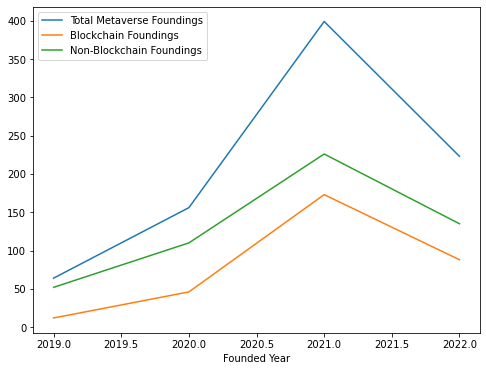

In [37]:

# See companies founded by year
# In all cases drop 2023 as year is unfinished
df_group_year = df.groupby("Founded Year")["Founded Year"].count().drop(labels=2023)

# See non-blockchain companies founded by year
df_no_blockchain = df[~df["Industries"].str.contains("Blockchain")]
no_blockchain_grouped = (
    df_no_blockchain.groupby("Founded Year")["Founded Year"]
    .count()
    .drop(labels=2023)
)

# # See specifically blockchain companies founded by year
df_blockchain = df[df["Industries"].str.contains("Blockchain")]
blockchain_grouped = (
    df_blockchain.groupby("Founded Year")["Founded Year"].count().drop(labels=2023)
)

# Plot

fig, ax = plt.subplots(figsize=(8,6))

df_group_year.plot(kind="line", ax=ax, label="Total Metaverse Foundings")
blockchain_grouped.plot(kind="line", ax=ax, label="Blockchain Foundings")
no_blockchain_grouped.plot(kind="line", ax=ax, label="Non-Blockchain Foundings")

plt.legend()
plt.show()

We can see immediately that 2021 was the top of the market for this (write more later). 

What about by region? Let's look at the top 10 locations for startup headquarters in this space:

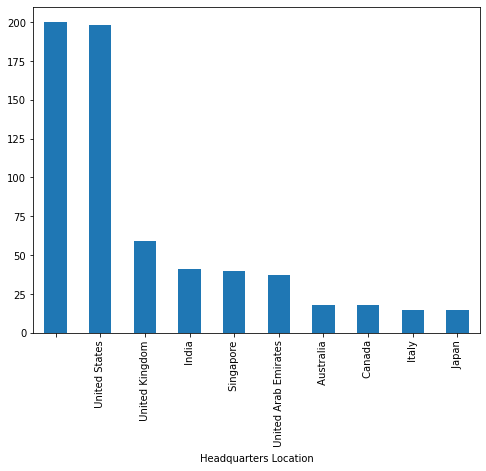

In [38]:
# By region 

fig2, ax2 = plt.subplots(figsize=(8,6))

reg_col = "Headquarters Location"

regions = df.groupby(reg_col)[reg_col].count()

main_regions = regions.nlargest(10, keep="first")

main_regions.plot(kind="bar", ax=ax2, label="Foundings By Region")

plt.show()

We have:
- Strong primary presence in anglosphere (USA, UK, Australia, Canada)
- Some secondary markets in South-East Asia (India, Singapore) and MENA (UAE)

What does this look like over time? Let's look at foundings per region over time: 

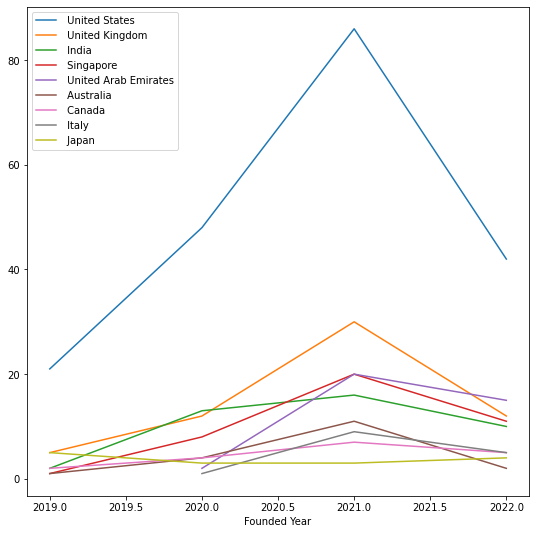

In [39]:
fig3, ax3 = plt.subplots(figsize=(9, 9))

for country in main_regions.keys():
    if country == "":
        continue;
    df_country = df[df[reg_col].str.contains(country)]
    df_country_grouped = (
        df_country.groupby("Founded Year")["Founded Year"].count().drop(2023, errors='ignore')
    )
    df_country_grouped.plot(kind="line", ax=ax3, label=country)

plt.legend()
plt.show()

We can see that outside of the anglosphere the percentage drop in foundings is not nearly quite so severe. In Japan foundings have actually increased whilst in India and the United Arab Emirates the rate of foundings has not declined quite so much. It may be that the financial difficulties in the United States have not propagated to the broader world to date, or there may be other Economic fundamentals at play.

## Funding and Growth

We note that none of the companies are currently actively hiring (at least according to crunchbase).

Beyond that, we note a signficant difference in funding for music vs non-music startups in this space:

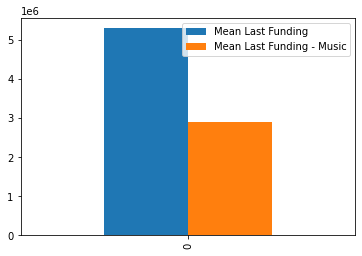

In [40]:
music_comps = df[df["Industries"].str.contains("Music")]

funding_col = 'Last Funding (USD)'

mean_last_funding = df[funding_col].mean()
music_last_funding = music_comps[funding_col].mean()

funding_df = pd.DataFrame({
    "Mean Last Funding": [mean_last_funding],
    "Mean Last Funding - Music": [music_last_funding]
})

funding_df.plot(kind='bar')
plt.show()

Lastly, the small number of companies involved in the music space bears listing due to their small number: 

In [41]:
pd.set_option('display.max_colwidth', None)
print(music_comps[["Organization Name", "Number of Employees"]])

         Organization Name Number of Employees
130                Stage11               11-50
150               Dequency                 NaN
155               HitPiece               11-50
166                Musixen               11-50
258        22block Studios                1-10
301       VerseBooks, Inc.                1-10
363                PatchXR               11-50
377  A.V. Mapping Co., LTD                1-10
387             Musicverse                1-10
435           Ristband Inc                1-10
452        Animal Concerts               11-50
453           Roar Studios               11-50
459          Vibes + Logic               11-50
501            limbo music               11-50
675      Melanated Studios               11-50
735                  +VIVO                1-10


.

## Team Size

<AxesSubplot:xlabel='Number of Employees'>

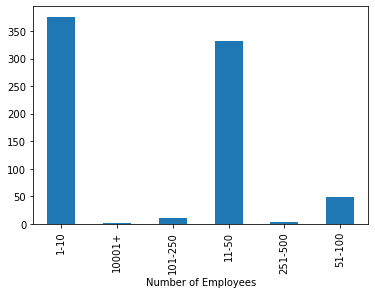

In [42]:
team_size_col = "Number of Employees"

team_size = df.groupby(team_size_col)[team_size_col].count()

team_size.plot(kind="bar")

<AxesSubplot:xlabel='Number of Employees'>

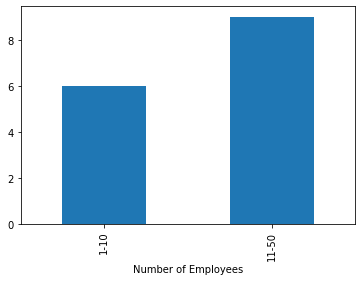

In [43]:
music_size = music_comps.groupby(team_size_col)[team_size_col].count()

music_size.plot(kind="bar")
